In [11]:
#@title Step 1: Data Loading and Initial Exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load the data
df=pd.read_csv("togo-dapaong_qc.csv")
print(df.shape)
print(df.columns.tolist())

(525600, 19)
['Timestamp', 'GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'Tamb', 'RH', 'WS', 'WSgust', 'WSstdev', 'WD', 'WDstdev', 'BP', 'Cleaning', 'Precipitation', 'TModA', 'TModB', 'Comments']


In [15]:
#@title Step 2: Data Profiling & Missing Value Analysis
# Basic info
print("=== DATASET INFO ===")
print(df.info())
print("\n=== SUMMARY STATISTICS ===")
print(df.describe())

# Missing value analysis
print("\n=== MISSING VALUES ===")
missing_data=df.isna().sum()
missing_percent=(missing_data/len(df))*100
missing_report=pd.DataFrame({
    'missing_data':missing_data,
    'missing_percent':missing_percent
})
print(missing_report)
high_missing=missing_report[missing_report['missing_percent']>5]
print(f"\nColumns with >5% missing values: {len(high_missing)}")
print(high_missing.index.tolist())

=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA          525600 non-null  float64
 17  TModB   

In [16]:
#@title Step 3: Outlier Detection & Data Cleaning
# Convert timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['Date'] = df['Timestamp'].dt.date

# Key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Calculate Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[key_columns].select_dtypes(include=[np.number])))
outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers (|Z| > 3): {outliers.sum()}")

# Create cleaned dataset (remove outliers)
df_clean = df[~outliers].copy()

# Handle missing values in key columns (median imputation)
for col in key_columns:
    if df_clean[col].isna().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

print(f"Original dataset shape: {df.shape}")
print(f"Cleaned dataset shape: {df_clean.shape}")


Number of outliers (|Z| > 3): 9251
Original dataset shape: (525600, 21)
Cleaned dataset shape: (516349, 21)


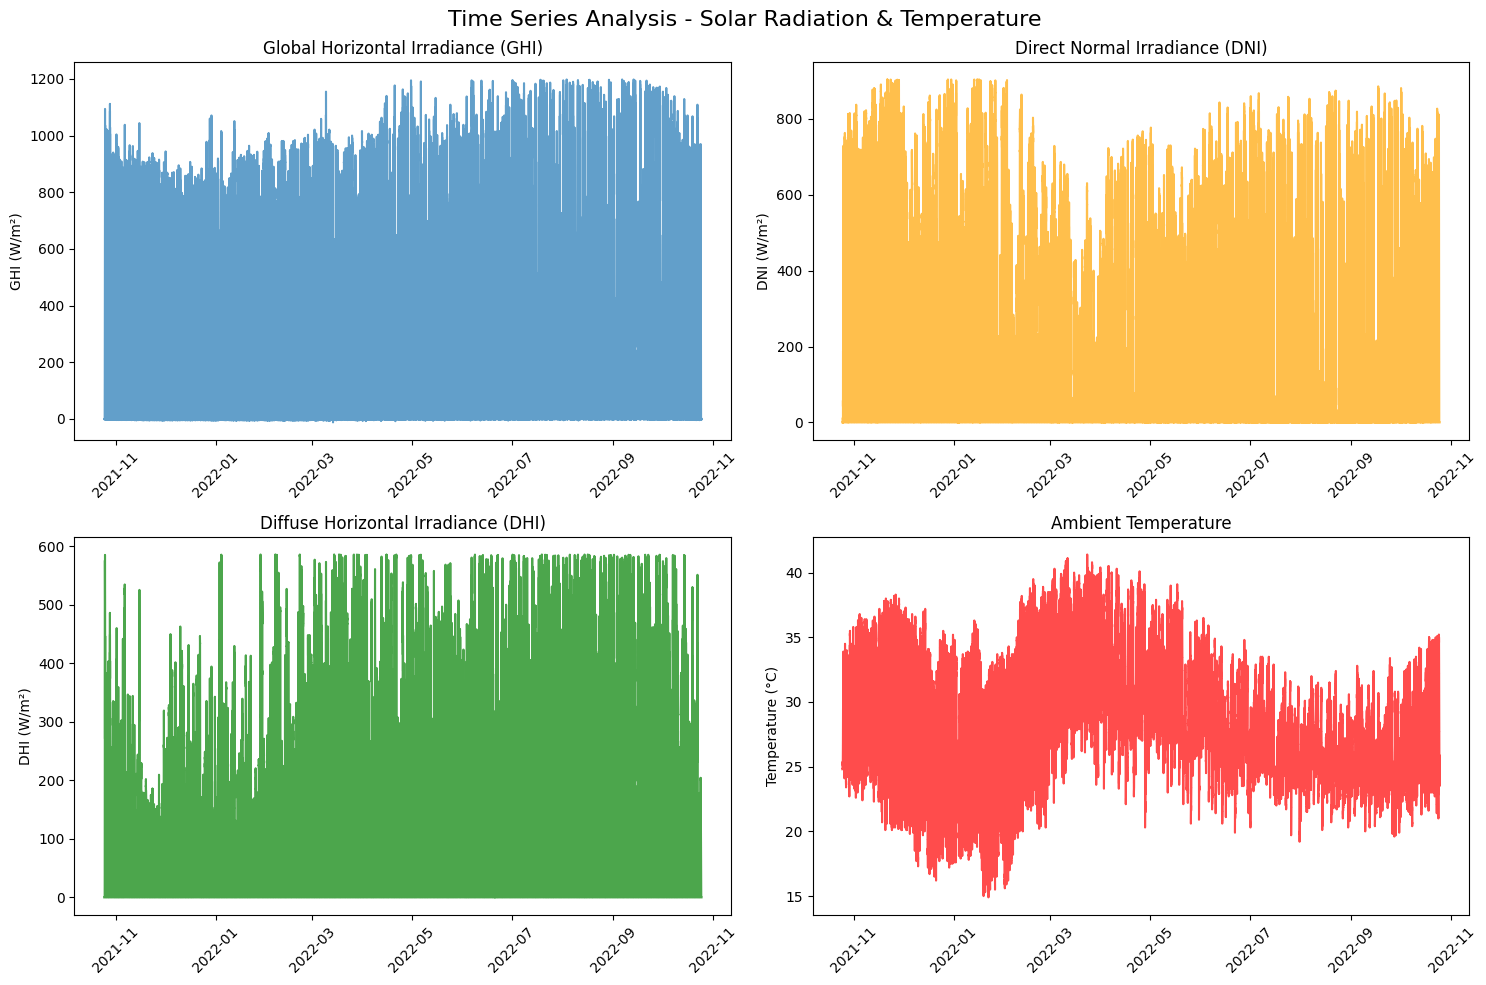

In [17]:
#@title Step 4: Time Series Analysis

# Set up plotting style
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Time Series Analysis - Solar Radiation & Temperature', fontsize=16)

# GHI over time
axes[0,0].plot(df_clean['Timestamp'], df_clean['GHI'], alpha=0.7)
axes[0,0].set_title('Global Horizontal Irradiance (GHI)')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].tick_params(axis='x', rotation=45)

# DNI over time
axes[0,1].plot(df_clean['Timestamp'], df_clean['DNI'], alpha=0.7, color='orange')
axes[0,1].set_title('Direct Normal Irradiance (DNI)')
axes[0,1].set_ylabel('DNI (W/m²)')
axes[0,1].tick_params(axis='x', rotation=45)

# DHI over time
axes[1,0].plot(df_clean['Timestamp'], df_clean['DHI'], alpha=0.7, color='green')
axes[1,0].set_title('Diffuse Horizontal Irradiance (DHI)')
axes[1,0].set_ylabel('DHI (W/m²)')
axes[1,0].tick_params(axis='x', rotation=45)

# Temperature over time
axes[1,1].plot(df_clean['Timestamp'], df_clean['Tamb'], alpha=0.7, color='red')
axes[1,1].set_title('Ambient Temperature')
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

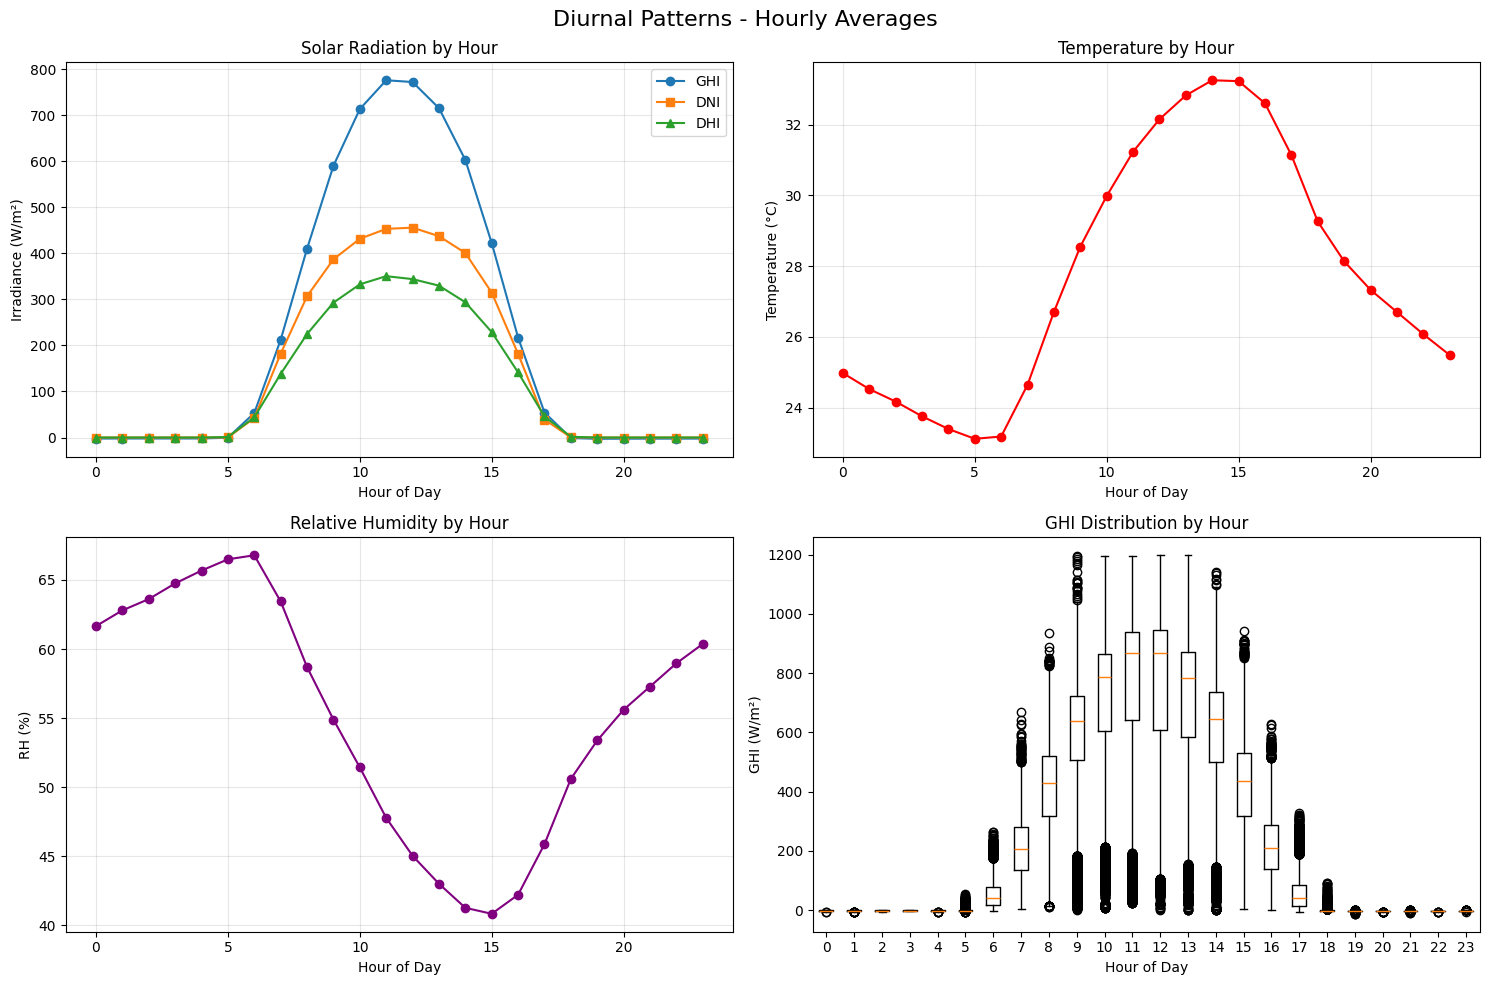

In [18]:
#@title Step 5: Diurnal Patterns Analysis
# Hourly averages
hourly_avg = df_clean.groupby('Hour').agg({
    'GHI': 'mean',
    'DNI': 'mean',
    'DHI': 'mean',
    'Tamb': 'mean',
    'RH': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Diurnal Patterns - Hourly Averages', fontsize=16)

# Solar radiation by hour
axes[0,0].plot(hourly_avg['Hour'], hourly_avg['GHI'], label='GHI', marker='o')
axes[0,0].plot(hourly_avg['Hour'], hourly_avg['DNI'], label='DNI', marker='s')
axes[0,0].plot(hourly_avg['Hour'], hourly_avg['DHI'], label='DHI', marker='^')
axes[0,0].set_title('Solar Radiation by Hour')
axes[0,0].set_ylabel('Irradiance (W/m²)')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Temperature by hour
axes[0,1].plot(hourly_avg['Hour'], hourly_avg['Tamb'], color='red', marker='o')
axes[0,1].set_title('Temperature by Hour')
axes[0,1].set_ylabel('Temperature (°C)')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].grid(True, alpha=0.3)

# RH by hour
axes[1,0].plot(hourly_avg['Hour'], hourly_avg['RH'], color='purple', marker='o')
axes[1,0].set_title('Relative Humidity by Hour')
axes[1,0].set_ylabel('RH (%)')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].grid(True, alpha=0.3)

# GHI distribution by hour
box_data = [df_clean[df_clean['Hour'] == h]['GHI'].values for h in range(24)]
axes[1,1].boxplot(box_data, positions=range(24))
axes[1,1].set_title('GHI Distribution by Hour')
axes[1,1].set_ylabel('GHI (W/m²)')
axes[1,1].set_xlabel('Hour of Day')

plt.tight_layout()
plt.show()

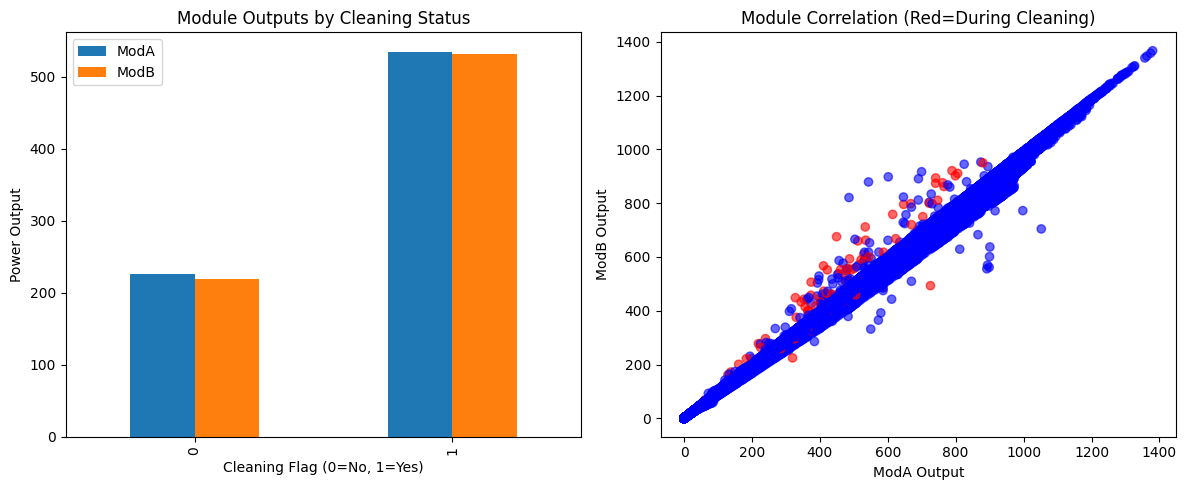

In [19]:
#@title Step 6: Cleaning Impact Analysis

# Group by Cleaning flag and compare module outputs
if 'Cleaning' in df.columns:
    cleaning_impact = df.groupby('Cleaning').agg({
        'ModA': 'mean',
        'ModB': 'mean'
    }).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Before and after cleaning comparison
    cleaning_impact.plot(x='Cleaning', y=['ModA', 'ModB'], kind='bar', ax=ax1)
    ax1.set_title('Module Outputs by Cleaning Status')
    ax1.set_ylabel('Power Output')
    ax1.set_xlabel('Cleaning Flag (0=No, 1=Yes)')

    # Scatter plot showing cleaning impact
    colors = ['red' if x == 1 else 'blue' for x in df['Cleaning']]
    ax2.scatter(df['ModA'], df['ModB'], c=colors, alpha=0.6)
    ax2.set_xlabel('ModA Output')
    ax2.set_ylabel('ModB Output')
    ax2.set_title('Module Correlation (Red=During Cleaning)')

    plt.tight_layout()
    plt.show()

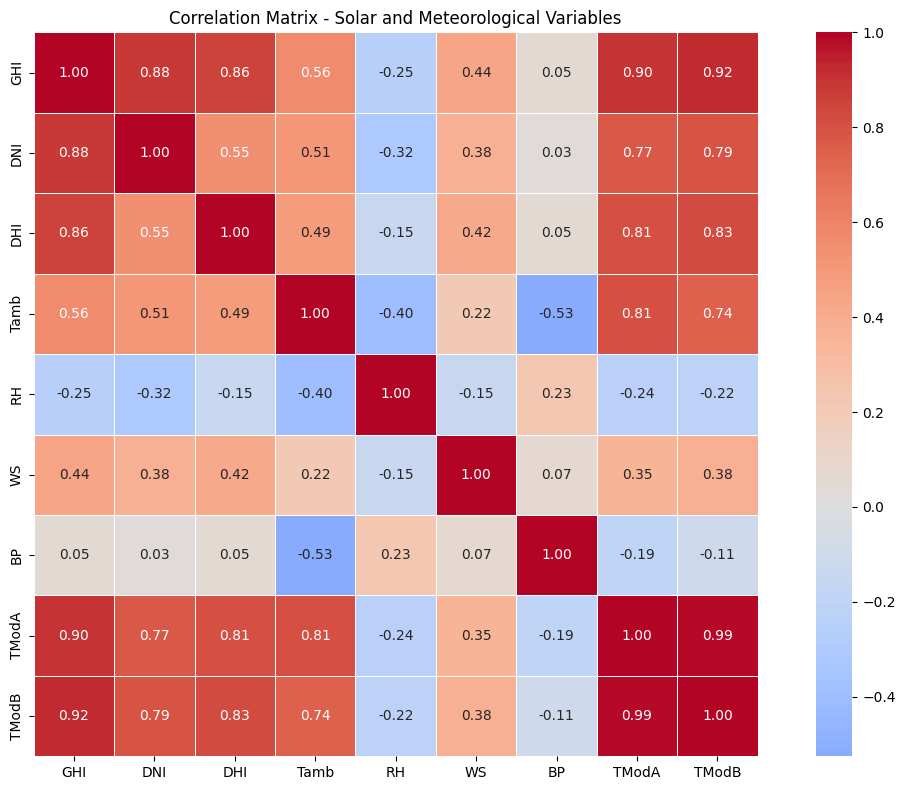

In [20]:
#@title Step 7: Correlation Analysis

# Select numeric columns for correlation
corr_columns = ['GHI', 'DNI', 'DHI', 'Tamb', 'RH', 'WS', 'BP', 'TModA', 'TModB']
corr_matrix = df_clean[corr_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
           square=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix - Solar and Meteorological Variables')
plt.tight_layout()
plt.show()

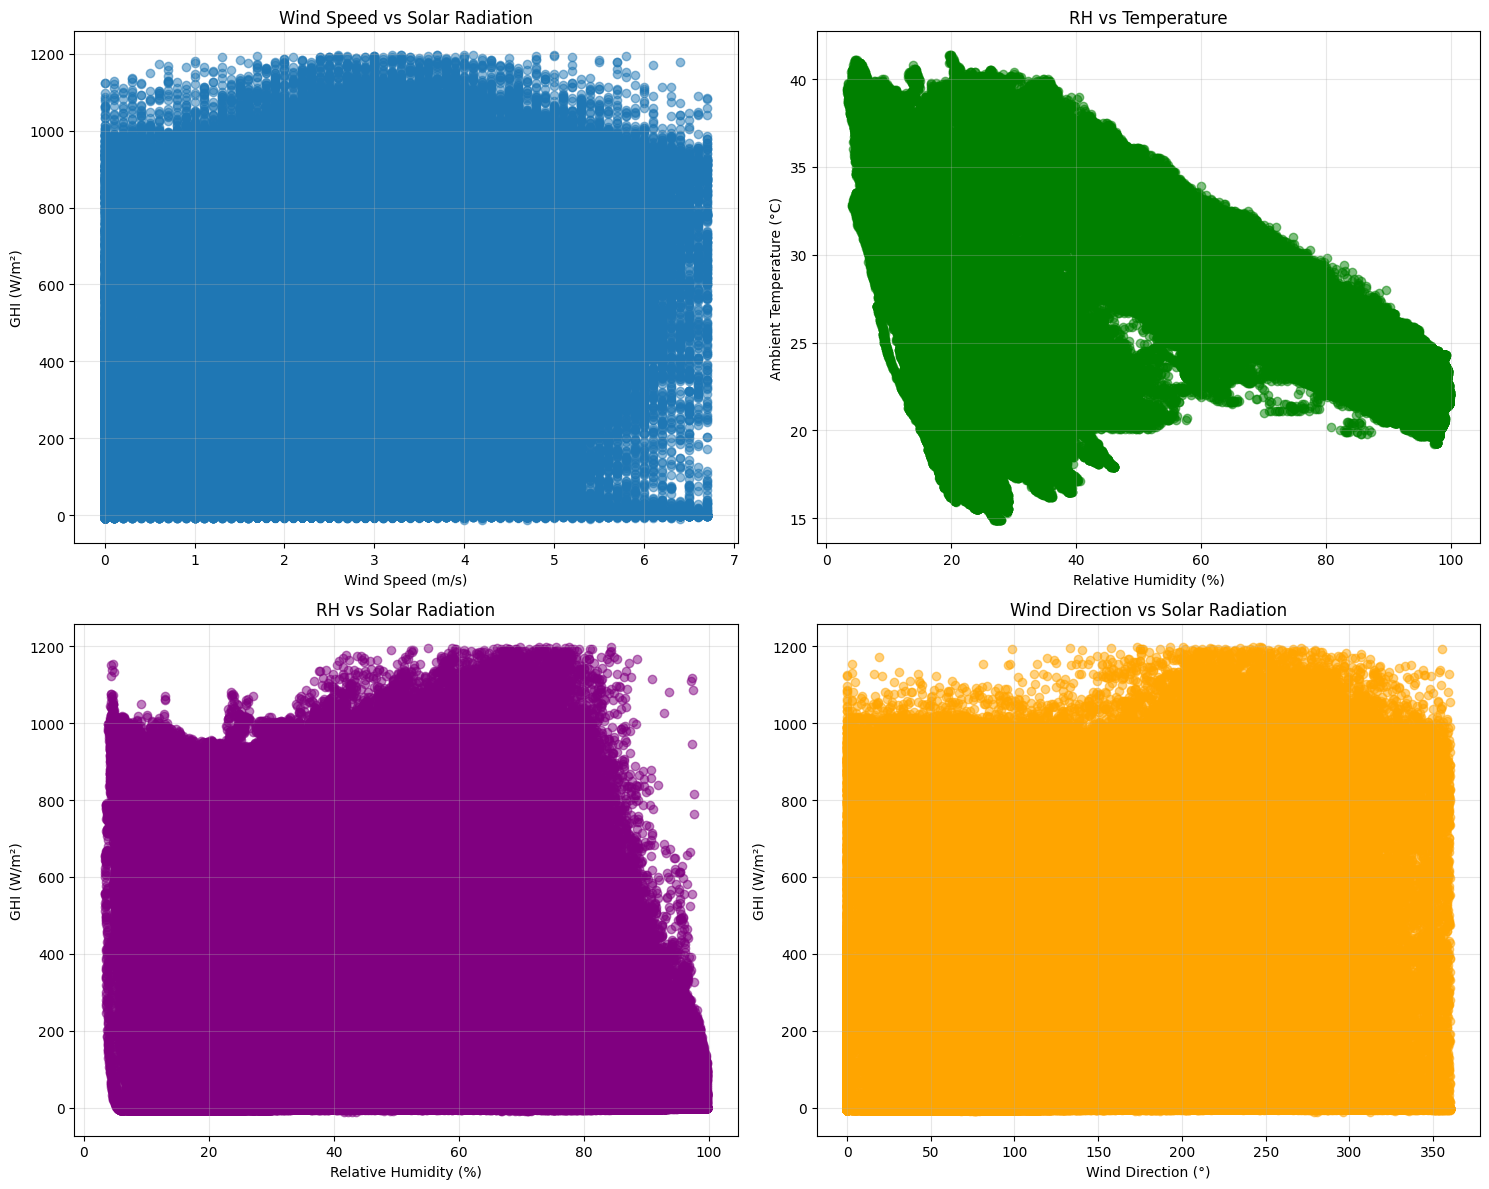

In [21]:
#@title Step 8: Scatter Plot Relationships

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# WS vs GHI
axes[0,0].scatter(df_clean['WS'], df_clean['GHI'], alpha=0.5)
axes[0,0].set_xlabel('Wind Speed (m/s)')
axes[0,0].set_ylabel('GHI (W/m²)')
axes[0,0].set_title('Wind Speed vs Solar Radiation')
axes[0,0].grid(True, alpha=0.3)

# RH vs Tamb
axes[0,1].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.5, color='green')
axes[0,1].set_xlabel('Relative Humidity (%)')
axes[0,1].set_ylabel('Ambient Temperature (°C)')
axes[0,1].set_title('RH vs Temperature')
axes[0,1].grid(True, alpha=0.3)

# RH vs GHI
axes[1,0].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.5, color='purple')
axes[1,0].set_xlabel('Relative Humidity (%)')
axes[1,0].set_ylabel('GHI (W/m²)')
axes[1,0].set_title('RH vs Solar Radiation')
axes[1,0].grid(True, alpha=0.3)

# WD vs GHI (wind direction)
axes[1,1].scatter(df_clean['WD'], df_clean['GHI'], alpha=0.5, color='orange')
axes[1,1].set_xlabel('Wind Direction (°)')
axes[1,1].set_ylabel('GHI (W/m²)')
axes[1,1].set_title('Wind Direction vs Solar Radiation')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

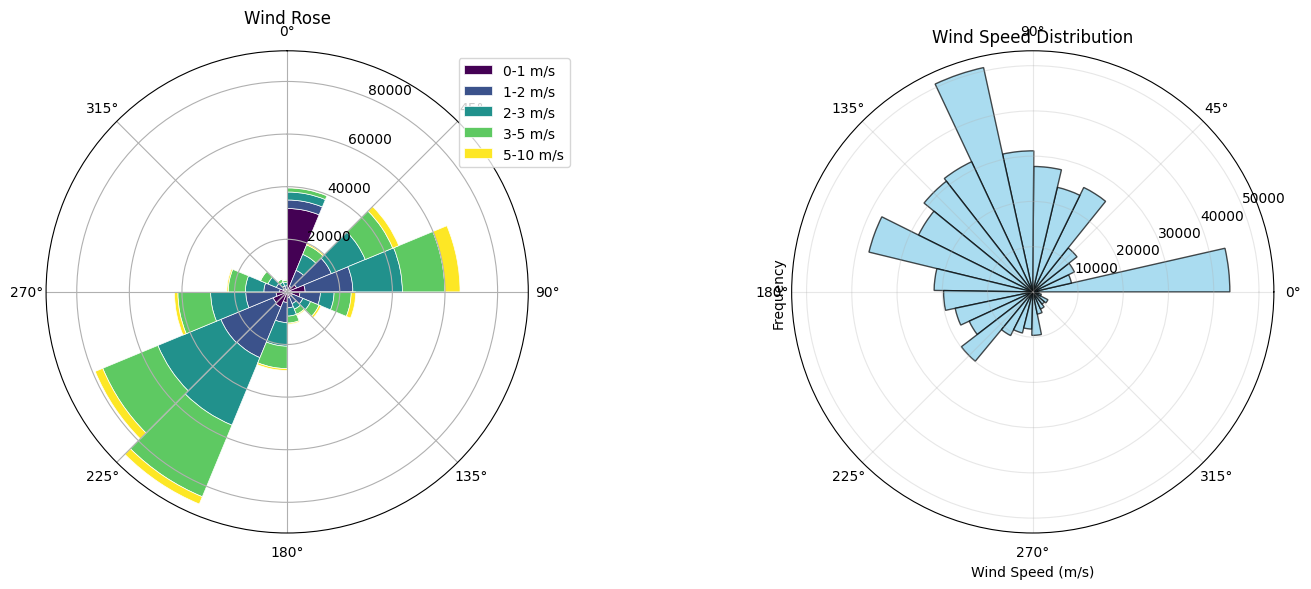

In [22]:
#@title Step 9: Wind Analysis
# Wind rose analysis
def plot_wind_rose(wind_dir, wind_speed, ax):
    """Simple wind rose plot"""
    # Bin wind directions into 16 sectors (22.5° each)
    sectors = 16
    sector_angle = 360 / sectors

    # Create bins
    dir_bins = np.linspace(0, 360, sectors + 1)
    speed_bins = [0, 1, 2, 3, 5, 10]  # m/s

    # Count frequencies
    counts = []
    for i in range(sectors):
        mask = (wind_dir >= dir_bins[i]) & (wind_dir < dir_bins[i+1])
        sector_counts = []
        for j in range(len(speed_bins)-1):
            speed_mask = (wind_speed >= speed_bins[j]) & (wind_speed < speed_bins[j+1])
            sector_counts.append(np.sum(mask & speed_mask))
        counts.append(sector_counts)

    counts = np.array(counts)

    # Plot
    theta = np.deg2rad(dir_bins[:-1] + sector_angle/2)
    width = np.deg2rad(sector_angle)

    colors = plt.cm.viridis(np.linspace(0, 1, len(speed_bins)-1))
    bottom = np.zeros(sectors)

    for i in range(len(speed_bins)-1):
        ax.bar(theta, counts[:, i], width=width, bottom=bottom,
               color=colors[i], edgecolor='white', linewidth=0.5,
               label=f'{speed_bins[i]}-{speed_bins[i+1]} m/s')
        bottom += counts[:, i]

    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    ax.set_title('Wind Rose', pad=20)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), subplot_kw=dict(projection='polar'))

# Wind rose
plot_wind_rose(df_clean['WD'], df_clean['WS'], ax1)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

# Wind speed histogram
ax2.hist(df_clean['WS'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax2.set_xlabel('Wind Speed (m/s)')
ax2.set_ylabel('Frequency')
ax2.set_title('Wind Speed Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

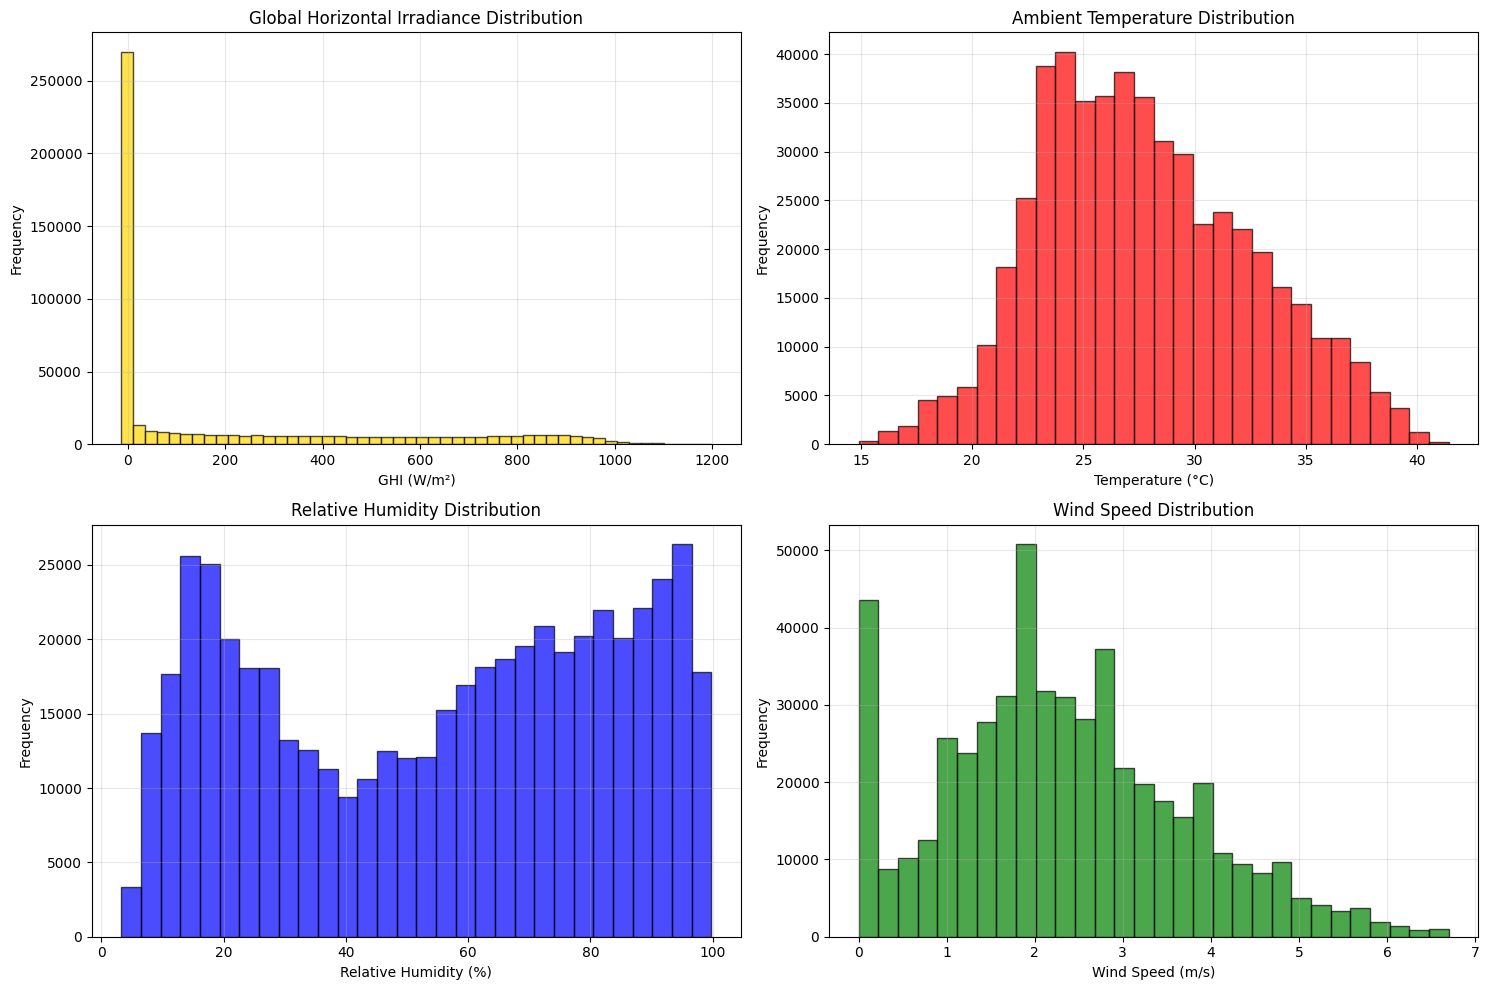

In [23]:
#@title Step 10: Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# GHI distribution
axes[0,0].hist(df_clean['GHI'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[0,0].set_xlabel('GHI (W/m²)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Global Horizontal Irradiance Distribution')
axes[0,0].grid(True, alpha=0.3)

# Temperature distribution
axes[0,1].hist(df_clean['Tamb'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0,1].set_xlabel('Temperature (°C)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Ambient Temperature Distribution')
axes[0,1].grid(True, alpha=0.3)

# RH distribution
axes[1,0].hist(df_clean['RH'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[1,0].set_xlabel('Relative Humidity (%)')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Relative Humidity Distribution')
axes[1,0].grid(True, alpha=0.3)

# WS distribution
axes[1,1].hist(df_clean['WS'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[1,1].set_xlabel('Wind Speed (m/s)')
axes[1,1].set_ylabel('Frequency')
axes[1,1].set_title('Wind Speed Distribution')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

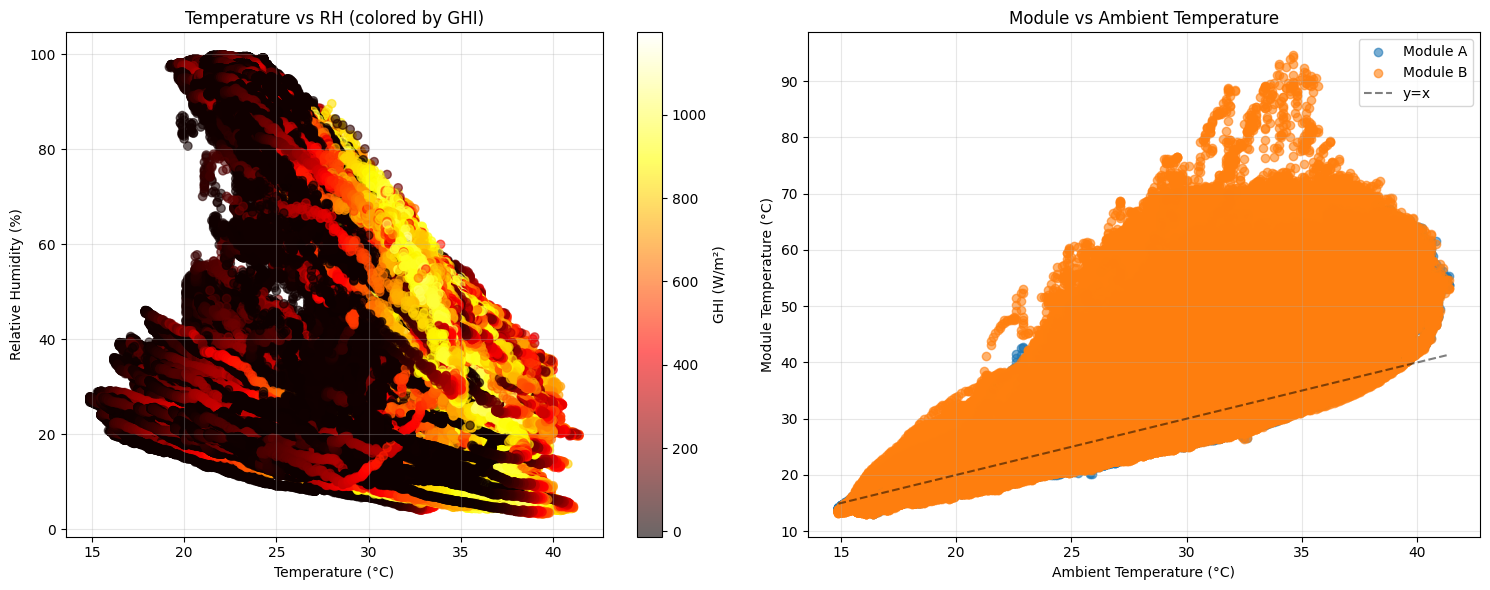

In [24]:
#@title Step 12: Temperature-RH Relationship Analysis

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Temperature vs RH colored by GHI
sc1 = axes[0].scatter(df_clean['Tamb'], df_clean['RH'], c=df_clean['GHI'],
                     cmap='hot', alpha=0.6)
plt.colorbar(sc1, ax=axes[0], label='GHI (W/m²)')
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Relative Humidity (%)')
axes[0].set_title('Temperature vs RH (colored by GHI)')
axes[0].grid(True, alpha=0.3)

# Module temperature vs ambient temperature
axes[1].scatter(df_clean['Tamb'], df_clean['TModA'], alpha=0.6, label='Module A')
axes[1].scatter(df_clean['Tamb'], df_clean['TModB'], alpha=0.6, label='Module B')
axes[1].plot([df_clean['Tamb'].min(), df_clean['Tamb'].max()],
            [df_clean['Tamb'].min(), df_clean['Tamb'].max()],
            'k--', alpha=0.5, label='y=x')
axes[1].set_xlabel('Ambient Temperature (°C)')
axes[1].set_ylabel('Module Temperature (°C)')
axes[1].set_title('Module vs Ambient Temperature')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
#@title Step 13: Export Cleaned Data

# Export cleaned dataset
df_clean.to_csv('datatogo_clean.csv', index=False)
print("Cleaned dataset exported to data/togo_clean.csv")

# Summary statistics for report
print("\n=== KEY INSIGHTS SUMMARY ===")
print(f"Data Collection Period: {df_clean['Timestamp'].min()} to {df_clean['Timestamp'].max()}")
print(f"Total Records: {len(df_clean)}")
print(f"Max GHI: {df_clean['GHI'].max():.1f} W/m²")
print(f"Average Temperature: {df_clean['Tamb'].mean():.1f}°C")
print(f"Average RH: {df_clean['RH'].mean():.1f}%")
print(f"Average Wind Speed: {df_clean['WS'].mean():.1f} m/s")

# Peak solar hours analysis
peak_ghi = df_clean[df_clean['GHI'] > df_clean['GHI'].quantile(0.9)]
print(f"Peak GHI hours (top 10%): {peak_ghi['Hour'].unique()}")

Cleaned dataset exported to data/togo_clean.csv

=== KEY INSIGHTS SUMMARY ===
Data Collection Period: 2021-10-25 00:01:00 to 2022-10-25 00:00:00
Total Records: 516349
Max GHI: 1198.0 W/m²
Average Temperature: 27.7°C
Average RH: 55.2%
Average Wind Speed: 2.3 m/s
Peak GHI hours (top 10%): [11 12 13  9 10 14 15  8]
